# **Μερική Διαφορική Εξίσωση Κύματος με PINN**

### **Προσεγγίζουμε την εξίσωση κύματος:**

$$
u_{tt} = c^2 u_{xx}
$$

### **Με:**

$$c = 1$$
$$x \in [-L, L], \; L = 2 $$
$$t \in [0, T], \; Τ = 5 $$

---

### **Αρχικές συνθήκες: (θέση και ταχύτητα)**

$$
u(x, 0) = f(x) = A \sin \left(\frac{\pi}{L} x \right)
$$

$$
u_t(x, 0) = g(x) = 0
$$

---

### **Συνοριακές συνθήκες (Dirichlet)**

$$
u(-L, t) = 0 \text{, για } t \in (0,sl) \cup (sr,T)
$$

$$
u(L, t) = 0 \text{, για } t \in (0,sl) \cup (sr,T)
$$

In [ ]:
import torch #βασικό πακέτο PyTorch
import torch.nn as nn #έτοιμες συναρτήσεις για νν
import torch.nn.functional as f #συναρτήσεις ενεργοποίησης
import torch.optim as optim #βελτιστοποιητές
import numpy as np #βιβλιοθήκη αριθμητικών υπολογισμών
from time import time #μέτρηση χρόνου
import gc #για καθαρισμό cpu
import platform #για το τι συσκευή cpu χρησιμοποιώ


use_cuda = input("Να κεράσω CUDA; (ναι/οχι): ").strip().lower()

if use_cuda == "ναι":
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

print("Χρήση συσκευής:", device)
print(torch.__version__)

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print("Κερασμένη η CUDA!")
  print("Current device:", torch.cuda.current_device())
  print("Device name:", torch.cuda.get_device_name(0))
  torch.cuda.empty_cache() # άδειασμα gpu
else:
  print("Μας τελείωσε η CUDA...")
  print(platform.uname())
  gc.collect() # άδειασμα cpu

#Ζέσταμα GPU για να μην πετάει warning
if device.type == "cuda":
    torch.cuda.init()
    torch.cuda.empty_cache()
    torch.randn(8, 8, device=device) #warm-up cuBLAS

Να κεράσω CUDA; (ναι/οχι): οχι
Χρήση συσκευής: cpu
2.9.0+cpu
False
Μας τελείωσε η CUDA...
uname_result(system='Linux', node='18a697f61b48', release='6.6.105+', version='#1 SMP Thu Oct  2 10:42:05 UTC 2025', machine='x86_64')


In [ ]:
#ορισμός ακρίβειας
dtype = torch.float32

#Σταθερές
pi = torch.tensor(np.pi, dtype=dtype, device=device) #π
wave_speed = torch.tensor(1, dtype=dtype, device=device) #ταχύτητα διάδοσης c
L = 2 #πλάτος χώρου
L_min = torch.tensor(-L, dtype=dtype, device=device) #πλάτος χώρου ελάχιστο
L_max = torch.tensor(L, dtype=dtype, device=device) #πλάτος χώρου μεγιστο
T_max = torch.tensor(5, dtype=dtype, device=device) #χρόνος
m = torch.tensor(1, dtype=dtype, device=device) #δείκτης μορφής κύματος
k = m*pi/L #κυματάριθμος
w = wave_speed * k #γωνιακή συχνότητα
A = torch.tensor(1, dtype=dtype, device=device) #σταθερά πλάτους κύματος

#Αρχικές Συνθήκες
def fun_u_0_th(t,x): #th=θέση
  return A * torch.sin(k*x)

def fun_u_0_ta(t,x): #ta=ταχύτητα
  n = t.shape[0] #πλήθος γραμμών
  return torch.zeros((n,1), dtype=dtype, device=device)
  #return k * wave_speed * torch.cos(k*(x+L))

#Συνοριακές Συνθήκες
def fun_u_b_left(t,x):
  n = x.shape[0] #πλήθος γραμμών
  return torch.zeros((n,1), dtype=dtype, device=device)

def fun_u_b_right(t,x):
  n = x.shape[0] #πλήθος γραμμών
  return torch.zeros((n,1), dtype=dtype, device=device)

#ΜΔΕ Εξίσωση Κύματος
def fun_r(u_tt, u_xx):
  return u_tt - wave_speed**2 * u_xx

In [ ]:
#Αριθμός σημείων
N_0 = 400 #πλήθος αρχικής συνθήκης u(x,0) και u_x(x,0)
N_b = 500 #πλήθος συνοριακών συνθηκών u(0, t) και u(1,t)
N_r = 2000 #πλήθος στο εσωτερικό του πεδίου εκπαίδευσης της ΜΔΕ

#Συνοριακές τιμές
tmin = torch.tensor(0, dtype=dtype, device=device)
tmax = T_max
xmin = L_min
xmax = L_max

In [ ]:
print(f'Τα όρια του χωροχρονικού πεδίου σε μορφή tensor:\n')
print(f'[tmin,tmax] x [xmin,xmax]')
print(f'[{tmin}, {tmax.item()}] x [{xmin}, {xmax.item()}]\n')

Τα όρια του χωροχρονικού πεδίου σε μορφή tensor:

[tmin,tmax] x [xmin,xmax]
[0.0, 5.0] x [-2.0, 2.0]



In [ ]:
#Κάτω όριο
lb = torch.tensor([tmin, xmin], dtype=dtype, device=device)
#Πάνω όριο
ub = torch.tensor([tmax, xmax], dtype=dtype, device=device)

In [ ]:
print(f'lb:', lb.device)
print(f'ub:', ub.device)

lb: cpu
ub: cpu


In [ ]:
#Σταθεροποίηση γεννήτριας τυχαίων αριθμών
torch.manual_seed(67)

In [ ]:
#Δημιουργία σημείων αρχικών συνθηκών


#στήλη με την αρχική τιμή του χρόνου
t_0 = torch.ones((N_0,1), dtype=dtype, requires_grad=True, device=device)*lb[0]
###t_0 = torch.ones((N_0,1), dtype=dtype, device=device)*lb[0]

#στήλη με τυχαίους στο διάστημα [xmin,xmax]
x_0 = torch.rand((N_0,1), dtype=dtype, requires_grad=True, device=device)*(ub[1]-lb[1]) + lb[1]
###x_0 = torch.rand((N_0,1), dtype=dtype, device=device)*(ub[1]-lb[1]) + lb[1]

#Συνδιασμός σε tensor (N0,2) ##δύο στήλες t0,x0
X_0 = torch.concat([t_0, x_0], dim=1)

In [ ]:
print(f't_0: ',t_0.shape)
print(f'x_0: ',x_0.shape)
print(f'X_0: ',X_0.shape)
print(f't_0: ',t_0.device)
print(f'x_0: ',x_0.device)
print(f'X_0: ',X_0.device)

t_0:  torch.Size([400, 1])
x_0:  torch.Size([400, 1])
X_0:  torch.Size([400, 2])
t_0:  cpu
x_0:  cpu
X_0:  cpu


In [ ]:
#Υπολογισμός αρχικών συνθηκών
u_0_th = fun_u_0_th(t_0, x_0)
u_0_ta = fun_u_0_ta(t_0, x_0)

#Συνδιασμός σε tensor (N0,2)
u_0 = torch.concat([u_0_th, u_0_ta], dim=1)

In [ ]:
print(f'u_0_th: ',u_0_th.shape)
print(f'u_0_ta: ',u_0_ta.shape)
print(f'u_0:    ',u_0.shape)
print(f'u_0_th: ',u_0_th.device)
print(f'u_0_ta: ',u_0_ta.device)
print(f'u_0:    ',u_0.device)

u_0_th:  torch.Size([400, 1])
u_0_ta:  torch.Size([400, 1])
u_0:     torch.Size([400, 2])
u_0_th:  cpu
u_0_ta:  cpu
u_0:     cpu


In [ ]:
#Δημιουργία σημείων Συνοριακών Συνθηκών


#στήλη με τυχαίους στο διάστημα [tmin, tmax]
###t_b = torch.rand((N_b,1), dtype=dtype, requires_grad=True, device=device)*(ub[0]-lb[0]) + lb[0]
t_b = torch.rand((N_b,1), dtype=dtype, device=device)*(ub[0]-lb[0]) + lb[0]

#στήλη με N_b στοιχεία για το xmin σύνορο (αριστερά)
###x_b_left = torch.ones((N_b, 1), dtype=dtype, requires_grad=True, device=device)*lb[1]
x_b_left = torch.ones((N_b, 1), dtype=dtype, device=device)*lb[1]

#στήλη με N_b στοιχεία για το xmax σύνορο (δεξιά)
###x_b_right = torch.ones((N_b, 1), dtype=dtype, requires_grad=True, device=device)*ub[1]
x_b_right = torch.ones((N_b, 1), dtype=dtype, device=device)*ub[1]

#Συνδιασμός σε tensor (N_b,2)
X_b = torch.concat([t_b, x_b_left, x_b_right], dim=1)

In [ ]:
print(f't_b:       ',t_b.shape)
print(f'x_b_left:  ',x_b_left.shape)
print(f'x_b_right: ',x_b_right.shape)
print(f'X_b:       ',X_b.shape)
print(f't_b:       ',t_b.device)
print(f'x_b_left:  ',x_b_left.device)
print(f'x_b_right: ',x_b_right.device)
print(f'X_b:       ',X_b.device)

t_b:        torch.Size([500, 1])
x_b_left:   torch.Size([500, 1])
x_b_right:  torch.Size([500, 1])
X_b:        torch.Size([500, 3])
t_b:        cpu
x_b_left:   cpu
x_b_right:  cpu
X_b:        cpu


In [ ]:
#Δημιουργία κομματιού σημείων Συνοριακών Συνθηκών

shock_l = torch.tensor(1.0, dtype=dtype, device=device) #shock αριστερά
shock_r = torch.tensor(4.0, dtype=dtype, device=device) #shock δεξιά

#στήλη με τυχαίους στο διάστημα [tmin, t_crit_min]∪[t_crit_max,tmax]
t_crit_min = shock_l
t_crit_max = shock_r

mask = (t_b < t_crit_min) | (t_b > t_crit_max )  # Boolean OR
t_b_mask = t_b[mask]
x_b_left = x_b_left[mask]
x_b_right = x_b_right[mask]


#unsqueeze tensor από (mask,) σε (mask,1)
t_b = t_b_mask.unsqueeze(1)
x_b_left = x_b_left.unsqueeze(1)
x_b_right = x_b_right.unsqueeze(1)

X_b = torch.concat([t_b, x_b_left, x_b_right], dim=1)

In [ ]:
print(f'mask:      ',mask.shape)
print(f't_b:       ',t_b.shape)
print(f't_b_mask:  ',t_b_mask.shape)
print(f'x_b_left:  ',x_b_left.shape)
print(f'x_b_right: ',x_b_right.shape)
print(f'mask:      ',mask.device)
print(f't_b:       ',t_b.device)
print(f't_b_mask:  ',t_b_mask.device)
print(f'x_b_left:  ',x_b_left.device)
print(f'x_b_right: ',x_b_right.device)

mask:       torch.Size([500, 1])
t_b:        torch.Size([201, 1])
t_b_mask:   torch.Size([201])
x_b_left:   torch.Size([201, 1])
x_b_right:  torch.Size([201, 1])
mask:       cpu
t_b:        cpu
t_b_mask:   cpu
x_b_left:   cpu
x_b_right:  cpu


In [ ]:
print(f'Τα όρια του χωροχρονικού πεδίου ύστερα από το shock σε μορφή tensor:\n')
print(f'[tmin,tmax] x [xmin,xmax]')
print(f'([{tmin}, {shock_l:.3f}] U [{shock_r:.3f}, {tmax.item()}]) x [{xmin}, {xmax.item()}])\n')

Τα όρια του χωροχρονικού πεδίου ύστερα από το shock σε μορφή tensor:

[tmin,tmax] x [xmin,xmax]
([0.0, 1.000] U [4.000, 5.0]) x [-2.0, 2.0])



In [ ]:
#Υπολογισμός Συνοριακών Συνθηκών

#Αριστερό σύνορο
u_b_left = fun_u_b_left(t_b, x_b_left)

#Δεξί σύνορο
u_b_right = fun_u_b_right(t_b, x_b_right)

#Συνδιασμός σε tensor (N_b,1)
u_b = torch.concat([u_b_left, u_b_right], dim=1)

In [ ]:
print(f'u_b_left:  ',u_b_left.shape)
print(f'u_b_right: ',u_b_right.shape)
print(f'u_b:       ',u_b.shape)
print(f'u_b_left:  ',u_b_left.device)
print(f'u_b_right: ',u_b_right.device)
print(f'u_b:       ',u_b.device)

u_b_left:   torch.Size([201, 1])
u_b_right:  torch.Size([201, 1])
u_b:        torch.Size([201, 2])
u_b_left:   cpu
u_b_right:  cpu
u_b:        cpu


In [ ]:
#Τυχαία σημεία λύσης

#Δημιουργία τυχαίων τιμών στο χρόνο [tmin, tmax]
t_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True, device=device)*(ub[0]-lb[0]) + lb[0]

#Δημιουργία τυχαίων τιμών στο χώρο [xmin, xmax]
x_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True, device=device)*(ub[1]-lb[1]) + lb[1]

#Συνδιασμός σημείων σε tensor (N_r,2)
X_r = torch.concat([t_r, x_r], dim=1)

In [ ]:
print(f't_r: ',t_r.shape)
print(f'x_r: ',x_r.shape)
print(f'X_r: ',X_r.shape)
print(f't_r: ',t_r.device)
print(f'x_r: ',x_r.device)
print(f'X_r: ',X_r.device)

t_r:  torch.Size([2000, 1])
x_r:  torch.Size([2000, 1])
X_r:  torch.Size([2000, 2])
t_r:  cpu
x_r:  cpu
X_r:  cpu


In [ ]:
#λίστες

#(Ν_0,2) αρχικά σημεία, (Ν_b,3) συνοριακά σημεία
X_data = [X_0, X_b]

#(Ν_0,2) αρχικές τιμές, (Ν_b,2) συνοριακές τιμές
u_data = [u_0, u_b]

In [ ]:
print(f'X_data[0]==X_0: ',X_data[0].shape)
print(f'X_data[1]==X_b: ',X_data[1].shape)
print(f'u_data[0]==u_0: ',u_data[0].shape)
print(f'u_data[1]==u_b: ',u_data[1].shape)
print(f'X_data[0]==X_0: ',X_data[0].device)
print(f'X_data[1]==X_b: ',X_data[1].device)
print(f'u_data[0]==u_0: ',u_data[0].device)
print(f'u_data[1]==u_b: ',u_data[1].device)

X_data[0]==X_0:  torch.Size([400, 2])
X_data[1]==X_b:  torch.Size([201, 3])
u_data[0]==u_0:  torch.Size([400, 2])
u_data[1]==u_b:  torch.Size([201, 2])
X_data[0]==X_0:  cpu
X_data[1]==X_b:  cpu
u_data[0]==u_0:  cpu
u_data[1]==u_b:  cpu


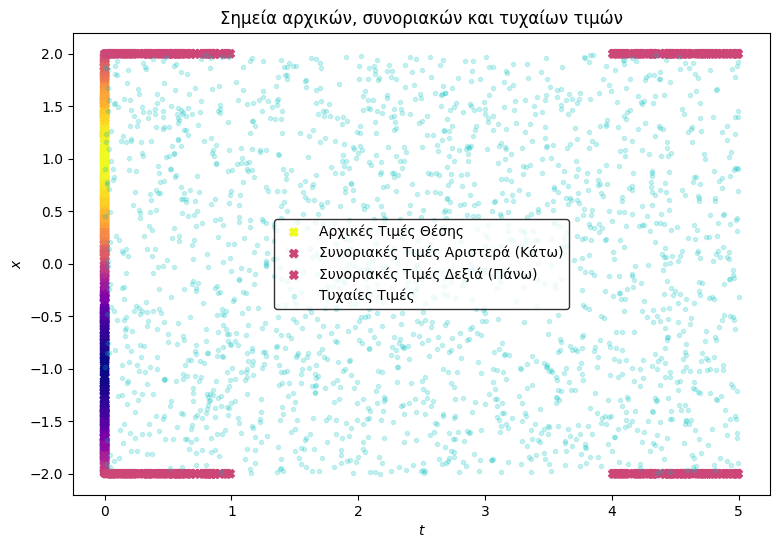

In [ ]:
import matplotlib.pyplot as plt #βιβλιοθήκη γραφήματα

fig = plt.figure(figsize=(9,6)) #καμβάς 9x6 ίντσες
color = 'plasma' #επιλογή χρώματος γραφίματος

#σημεία αρχικής συνθήκης
plt.scatter(t_0.cpu().detach(), x_0.cpu().detach(), c=u_0[:,[0]].cpu().detach(), marker='X', vmin=-1, vmax=1, cmap=color, label='Αρχικές Τιμές Θέσης')

#σημεία συνοριακών συνθηκών
plt.scatter(t_b.cpu().detach(), x_b_left.cpu().detach(), c=u_b[:,[0]].cpu().detach(), marker='X', vmin=-1, vmax=1, cmap=color, label='Συνοριακές Τιμές Αριστερά (Κάτω)')
plt.scatter(t_b.cpu().detach(), x_b_right.cpu().detach(), c=u_b[:,[1]].cpu().detach(), marker='X', vmin=-1, vmax=1, cmap=color, label='Συνοριακές Τιμές Δεξιά (Πάνω)')

#σημεία τυχαία
plt.scatter(t_r.cpu().detach(), x_r.cpu().detach(), c='c', marker='.', alpha=0.2, label='Τυχαίες Τιμές')

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(loc='center').get_frame().set_edgecolor('black')
plt.title('Σημεία αρχικών, συνοριακών και τυχαίων τιμών');
plt.show()

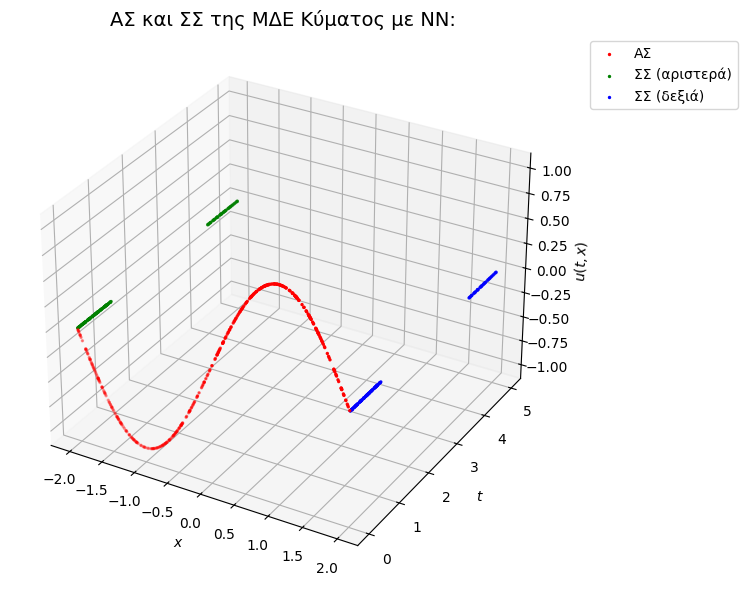

Στο t=Τ έχουμε min U_0 = -1.000, max U_0 = 1.000


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

#Αρχική Συνθήκη
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), u_0_th.detach().cpu().numpy(), color='r', label='ΑΣ', s=2);

#Συνοριακή Συνθήκη (Αριστερά)
ax.scatter(x_b_left.detach().cpu().numpy(), t_b.detach().cpu().numpy(), u_b_left.detach().cpu().numpy(), color='g', label='ΣΣ (αριστερά)', s=2);

#Συνοριακή Συνθήκη (Δεξιά)
ax.scatter(x_b_right.detach().cpu().numpy(), t_b.detach().cpu().numpy(), u_b_right.detach().cpu().numpy(), color='b', label='ΣΣ (δεξιά)', s=2);


ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(t,x)$')
ax.set_title(r'ΑΣ και ΣΣ της ΜΔΕ Κύματος με NN:', fontsize=14);
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Μέγιστο πλάτος στο t_max
U0_min = u_0_th.min().item()
U0_max = u_0_th.max().item()
print(f'Στο t=Τ έχουμε min U_0 = {U0_min:.3f}, max U_0 = {U0_max:.3f}')

In [ ]:
#Δημιουργία ΝΝ

class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        #Το input layer συνδέεται στο 1ο layer (με 20 νευρώνες)
        self.input_layer = nn.Linear(2, num_neurons_per_layer)

        #Τα layers από το 1ο μέχρι το 8ο
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer,num_neurons_per_layer)

            for _ in range(num_hidden_layers)
        ])

        #Το output layer δίνει πραγματική τιμή
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        #Αρχικοποίηση βαρών
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            #αποτρέπει τα πολύ μεγάλα και πολύ μικρά βάρη
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        #Μετασχηματιμσός του x για να βρίσκεται στο [lb[1], ub[1]]=[xmin,xmax]=[-1,1] για ταχύτερη επκπαίδευση με την tanh
        x = 2.0*(x - lb)/(ub - lb) - 1.0

        #Το input layer
        x = torch.tanh(self.input_layer(x))
        #1ο με 8ο hidden layer
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        #Το output layer
        x = self.output_layer(x)
        return x

In [ ]:
#Υπολογισμός Απώλειας

def compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag):

    ##Απώλεια ΜΔΕ
    #Σπάσιμο στηλών t,x για να υπολογιστούν ξεχωριστά οι μερικές παράγωγοι
    t = X_r[:,0:1]#.detach().requires_grad_(True)
    x = X_r[:,1:2]#.detach().requires_grad_(True)

    #Εκτίμηση ΜΔΕ μοντέλου
    u = model(torch.concat([t,x],dim=1))

    #Υπολογισμός Μερικών Παραγώγων
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]

    #Υπολογισμός του απώλειας της ΜΔΕ
    l_u = torch.mean(torch.square(fun_r(u_tt, u_xx)))


    ##Απώλεια αρχικής συνθήκης
    #Σπάσιμο του t0,x0 για να υπολογιστεί ξεχωριστά η μερική παράγωγος
    t0 = X_data[0][:,0:1]#.clone().detach().requires_grad_(True)
    x0 = X_data[0][:,1:2]#.detach().requires_grad_(True)

    #Εκτίμηση μοντέλου για την θέση και ταχύτητα
    u0 = model(torch.concat([t0, x0],dim=1))

    #Υπολογισμός μερικής παραγώγου
    u0_t0 = torch.autograd.grad(u0, t0, grad_outputs=torch.ones_like(u0), create_graph=True, allow_unused=True)[0]

    #Υπολογισμός απώλειας θέσης και ταχύτητας
    l_th = torch.mean(torch.square(u_data[0][:,0:1]-u0))
    l_ta = torch.mean(torch.square(u_data[0][:,1:2]-u0_t0))
    l_0 = l_th + l_ta


    ##Απώλεια συνοριακών τιμών Dirichlet
    #Σπάσιμο στηλών t,xl,xr για να υπολογιστούν ξεχωριστά οι μερικές παράγωγοι
    tb = X_data[1][:,0:1]#.clone().detach().requires_grad_(True)
    xbl = X_data[1][:,1:2]#.detach().requires_grad_(True)
    xbr = X_data[1][:,2:3]#.detach().requires_grad_(True)

    #Εκτίμηση μοντέλου Αριστερά
    ubl = model(torch.concat([tb, xbl],dim=1))

    #Εκτίμηση μοντέλου Δεξιά
    ubr = model(torch.concat([tb, xbr],dim=1))

    #Υπολογισμός απώλειας συνοριακών συνθηκών
    l_left = torch.mean(torch.square(u_data[1][:,0:1]-ubl))
    l_right = torch.mean(torch.square(u_data[1][:,1:2]-ubr))
    l_b = l_left + l_right

    #Προσαρμογή Βαρών κάθε loss
    w_u = 1
    w_b = 1
    w_0 = 1

    #Συνολική απώλεια
    loss = w_u * l_u + w_b * l_b + w_0 * l_0

    if (epochs % 100 == 0) and (verbose_flag != -1):
      print(f'Epoch {epochs:05d}: l_u = {l_u:10.8e}, l_b_left = {l_left:10.8e}, l_b_right = {l_right:10.8e} l_0_th = {l_th:10.8e}, l_0_ta = {l_ta:10.8e} loss = {loss:10.8e}')

    return loss

In [ ]:
model = NeuralNetwork().to(device)

# Έλεγχος ότι το μοντέλο πήγε στη GPU
print("Model is on:", next(model.parameters()).device)

#Σταθερά learning rate
lr_schedule = [5e-4, 1e-4, 1e-5]
def get_lr(epoch):
    if epoch < 100:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]

#Adam βελτιστοποιητής
optimizer = torch.optim.Adam(model.parameters(), lr=lr_schedule[0])

Model is on: cpu


In [ ]:
#Αριθμός εποχών
epochs=0
epoch = 2000
#Λίστα απώλειας κάθε εποχής
losses = []
#Καταγραφή χρόνου (σε δευτερόλεπτα)
sec = time()

for i in range(epoch):

    #Ενημέρωση της σταθεράς learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    #Μηδενισμός των παραγώγων του βελτιστοποιητή πριν το backpropagation
    optimizer.zero_grad()

    #Υπολογισμός σφάλματος
    loss = compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag=1)

    #Έλεγχος ποιες παράμετροι δεν είναι CUDA
    #for name, param in model.named_parameters():
        #if param.device.type != 'cuda':
            #print("Parameter on CPU:", name, param.device)

    #Υπολογισμός των παραγώγων τρέχουσας εποχής
    loss.backward(retain_graph=True)

    #Ενημέρωση βαρών επόμενης εποχής
    optimizer.step()

    #Αποθήκευση του σφάλματος κάθε εποχής
    losses.append(loss.item())

    #Για την εκτύπωση του loss
    epochs = epochs + 1

    #Εφαρμογή του early stopping
    if loss.item() < 1e-5:
       break

#Εμφάνιση χρόνου εκτέλεσης του μοντέλου
seconds = time() - sec
days = seconds // (24*60*60)
hours = (seconds % (24*60*60)) // (60*60)
minutes = (seconds % (60*60)) // 60
second = int(seconds % 60)
print(f'\nΧρόνος Εκπαίδευσης Μοντέλου: {int(days)} μέρες, {int(hours)} ώρες, {int(minutes)} λεπτά, {int(second)} δευτερόλεπτα')
print(f'\nEpochs: {epochs}, loss = {losses[epochs-1]:10.8e}')

Epoch 00000: l_u = 8.30191639e-05, l_b_left = 7.58807408e-03, l_b_right = 3.26225646e-02 l_0_th = 5.60784161e-01, l_0_ta = 3.31993870e-05 loss = 6.01110995e-01
Epoch 00100: l_u = 1.52143603e-02, l_b_left = 2.20763106e-02, l_b_right = 3.58564146e-02 l_0_th = 2.30807498e-01, l_0_ta = 1.48903001e-02 loss = 3.18844885e-01
Epoch 00200: l_u = 1.89193338e-02, l_b_left = 2.16387399e-02, l_b_right = 3.08590923e-02 l_0_th = 1.94957063e-01, l_0_ta = 2.59976909e-02 loss = 2.92371929e-01
Epoch 00300: l_u = 3.27235498e-02, l_b_left = 2.22969577e-02, l_b_right = 1.95813384e-02 l_0_th = 1.56142056e-01, l_0_ta = 2.97194626e-02 loss = 2.60463357e-01
Epoch 00400: l_u = 4.00463529e-02, l_b_left = 2.01914366e-02, l_b_right = 1.32835470e-02 l_0_th = 1.18275873e-01, l_0_ta = 2.64455825e-02 loss = 2.18242779e-01
Epoch 00500: l_u = 5.35038039e-02, l_b_left = 1.42555544e-02, l_b_right = 7.29634985e-03 l_0_th = 6.02020733e-02, l_0_ta = 7.97696412e-03 loss = 1.43234745e-01
Epoch 00600: l_u = 5.40269203e-02, l_b_l

In [ ]:
# Fine-tuning με L-BFGS

#Καταγραφή χρόνου (σε δευτερόλεπτα)
sec = time()

lbfgs_counter = 0  #μετρητής βημάτων LBFGS

optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),    #μεταβολή των βαρών του μοντέλου
                                    max_iter=500,          #μέγιστος αριθμός εσωτερικών βημάτων
                                    tolerance_grad=1e-7,   #έξοδος όταν η μέση κλίση είναι μικρότερη από
                                    tolerance_change=1e-9, #έξοδος όταν τα βάρη είναι μικρότερα από
                                    history_size=50,       #πόσα προηγούμενα βήματα να θυμάται για την εκτίμηση της Hessian
                                    line_search_fn="strong_wolfe") #για σταθερή σύγκλιση, αποφυγεί πολύ μικρών/μεγάλων βημάτων

def closure():
    optimizer_lbfgs.zero_grad() #μηδενισμός προηγούμενων gradients
    loss = compute_loss(model, X_r, X_data, u_data, epochs, verbose_flag=-1) #υπολογισμός απώλειας
    loss.backward(retain_graph=True) #υπολογισμός gradients
    global lbfgs_counter #για να την πάρει από έξω
    lbfgs_counter = lbfgs_counter + 1 #μετρητής βημάτων LBFGS
    return loss

#Μία κλήση LBFGS (κάνει εσωτερικά 500 αλληλεπιδράσεις)
optimizer_lbfgs.step(closure)

#Τελική αξιολόγηση μετά το LBFGS
loss_lbfgs = compute_loss(model, X_r, X_data, u_data, 0, verbose_flag=-1)

print(f"LBFGS Επανάληψη {lbfgs_counter}")
print(f"LBFGS Σφάλμα {loss_lbfgs.item():10.8e}")
print(f"LBFGS βελτίωση: Από {losses[-1]:10.8e} σε {loss_lbfgs.item():10.8e}")
print(f"Διαφορά LBFGS με Adam: {(loss_lbfgs.item() - losses[-1]):+10.8e}")

#Εμφάνιση χρόνου εκτέλεσης του LBFGS
seconds = time() - sec
days = seconds // (24*60*60)
hours = (seconds % (24*60*60)) // (60*60)
minutes = (seconds % (60*60)) // 60
second = int(seconds % 60)
print(f'\nΧρόνος Βελτιστοποίησης με LBFGS: {int(days)} μέρες, {int(hours)} ώρες, {int(minutes)} λεπτά, {int(second)} δευτερόλεπτα')

LBFGS Επανάληψη 520
LBFGS Σφάλμα 1.18270458e-03
LBFGS βελτίωση: Από 1.16668921e-02 σε 1.18270458e-03
Διαφορά LBFGS με Adam: -1.04841875e-02

Χρόνος Βελτιστοποίησης με LBFGS: 0 μέρες, 0 ώρες, 0 λεπτά, 27 δευτερόλεπτα


In [ ]:
input(f"Να συνεχίσω το προγραμμα' ; (ναι/οχι): ").strip().lower()

Να συνεχίσω το προγραμμα' ; (ναι/οχι): οχι


'οχι'

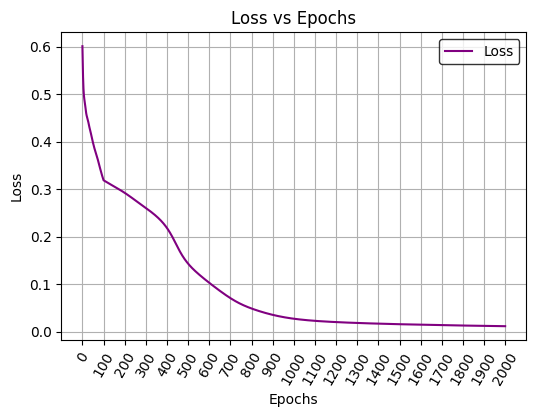

In [ ]:
#Απώλεια κάθε εποχής
fig = plt.figure(figsize=(6,4))

plt.plot(range(epochs), losses, label='Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(loc='upper right').get_frame().set_edgecolor('black')
plt.xticks(range(0, epoch+1, 100), rotation=60)
plt.grid(True)
plt.show()

u0_m:  torch.Size([400, 1])
ubl_m:  torch.Size([201, 1])
ubr_m:  torch.Size([201, 1])


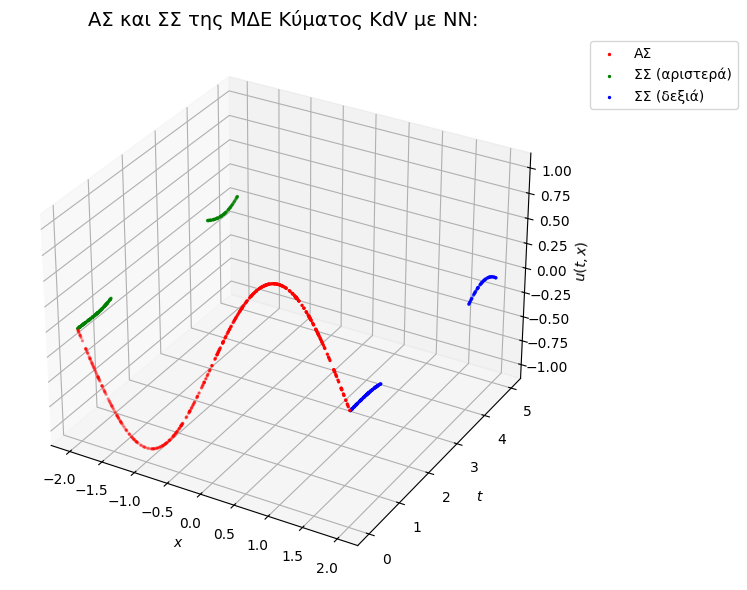

Στο t=Τ έχουμε min U_0 = -1.001, max U_0 = 0.999


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

#Τελική εκτίμηση μοντέλου Αρχικής Συνθήκης
u0_m = model(torch.concat([t_0, x_0],dim=1))
print(f'u0_m: ',u0_m.shape)

#Τελική εκτίμηση μοντέλου Συνοριακής Συνθήκης Αριστερά
ubl_m = model(torch.concat([t_b, x_b_left],dim=1))
print(f'ubl_m: ',ubl_m.shape)

#Τελική εκτίμηση μοντέλου Συνοριακής Συνθήκης Δεξιά
ubr_m = model(torch.concat([t_b, x_b_right],dim=1))
print(f'ubr_m: ',ubr_m.shape)

#Αρχική Συνθήκη
ax.scatter(x_0.detach().cpu().numpy(), t_0.detach().cpu().numpy(), u0_m.detach().cpu().numpy(), color='r', label='ΑΣ', s=2);

#Συνοριακή Συνθήκη (Αριστερά)
ax.scatter(x_b_left.detach().cpu().numpy(), t_b.detach().cpu().numpy(), ubl_m.detach().cpu().numpy(), color='g', label='ΣΣ (αριστερά)', s=2);

#Συνοριακή Συνθήκη (Δεξιά)
ax.scatter(x_b_right.detach().cpu().numpy(), t_b.detach().cpu().numpy(), ubr_m.detach().cpu().numpy(), color='b', label='ΣΣ (δεξιά)', s=2);


ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(t,x)$')
ax.set_title(r'ΑΣ και ΣΣ της ΜΔΕ Κύματος KdV με NN:', fontsize=14);
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Μέγιστο πλάτος στο t_max
U0_min = u0_m.min().item()
U0_max = u0_m.max().item()
print(f'Στο t=Τ έχουμε min U_0 = {U0_min:.3f}, max U_0 = {U0_max:.3f}')

Για t=[0,T] έχουμε min U = -1.021, max U = 1.057
Στο t=Τ έχουμε min U = -0.269, max U = 0.279


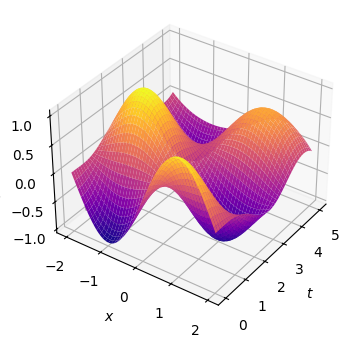

In [ ]:
from mpl_toolkits.mplot3d import Axes3D #βιβλιοθήκη για 3D γραφήματα

#Πλήθος διαστημάτων
N = 1000

tmin = tmin.cpu().item()
tmax = tmax.cpu().item()
xmin = xmin.cpu().item()
xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

#Γράφημα πρόβλεψης u(t,x) από δύο οπτικές γωνίες
fig = plt.figure(figsize=(6,4))
#fig.suptitle('Μοντελοποίηση ΜΔΕ Dirichlet Κύματος με NN:\n Αποτελέσματα Προβλέψεων', fontsize=14)

ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(T, X, U, cmap='plasma');
ax1.view_init(35,35)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$u(t,x)$')

ax1.invert_xaxis()


print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')

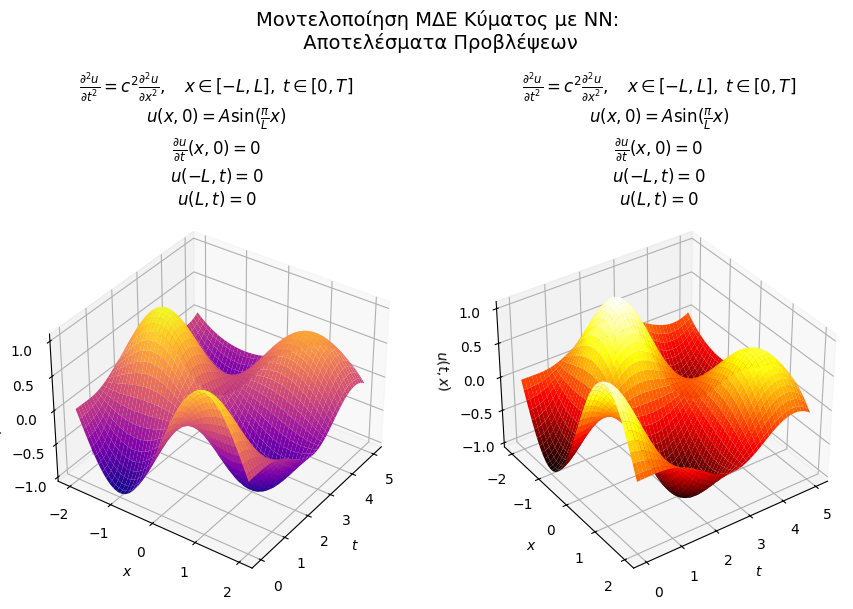

Για t=[0,T] έχουμε min U = -1.021, max U = 1.057
Στο t=Τ έχουμε min U = -0.269, max U = 0.279


In [ ]:
from mpl_toolkits.mplot3d import Axes3D #βιβλιοθήκη για 3D γραφήματα

#Πλήθος διαστημάτων
N = 1000

#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

#Γράφημα πρόβλεψης u(t,x) από δύο οπτικές γωνίες
fig = plt.figure(figsize=(9,6))
fig.suptitle('Μοντελοποίηση ΜΔΕ Κύματος με NN:\n Αποτελέσματα Προβλέψεων', fontsize=14)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T, X, U, cmap='plasma');
ax1.view_init(35,215)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$u(t,x)$')
ax1.set_title(r'$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2},\quad x \in [-L, L],\ t \in [0,T]$' '\n'
              r'$u(x, 0) = A \sin(\frac{\pi}{L} x)$' '\n'
              r'$\frac{\partial u}{\partial t}(x, 0) = 0$' '\n'
              r'$u(-L, t) = 0$' '\n'
              r'$u(L, t) = 0$',
              fontsize=12);
ax1.invert_yaxis()

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T, X, U, cmap='hot');
ax2.view_init(35,235)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$x$')
ax2.set_zlabel('$u(t,x)$')
ax2.set_title(r'$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2},\quad x \in [-L, L],\ t \in [0,T]$' '\n'
              r'$u(x, 0) = A \sin(\frac{\pi}{L} x)$' '\n'
              r'$\frac{\partial u}{\partial t}(x, 0) = 0$' '\n'
              r'$u(-L, t) = 0$' '\n'
              r'$u(L, t) = 0$',
              fontsize=12);
ax2.invert_yaxis()

# Εμφάνιση του αποτελέσματος
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')

In [ ]:
import plotly.graph_objects as go

#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()

#Δημιουργία σημείων
tspace = np.linspace(tmin, tmax, N + 1) #(N+1,1)
xspace = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T, X = np.meshgrid(tspace, xspace) #(N+1,N+1) , (N+1,N+1)

#τίτλος
lines = (
    r'<b>Μοντελοποίηση ΜΔΕ Κύματος με NN<b>',
    r'$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2},\quad x \in [-L, L],\ t \in [0,T]$',
    r'$u(x, 0) = A \sin(\frac{\pi}{L} x)$',
    r'$\frac{\partial u}{\partial t}(x, 0) = 0$',
    r'$u(-L, t) = 0$',
    r'$u(L, t) = 0$'
)

#δημιουργία γραμμών τίτλου
annotations = []
x_pos = 0.05
start_y = 1.05
dy = -0.055

for i, line in enumerate(lines):
    annotations.append(
        dict(
          text=line,
          x=x_pos,
          y=start_y + i * dy,
          xref='paper',
          yref='paper',
          showarrow=False,
          font=dict(size=13 if i > 0 else 16, family="Arial"),
          align='center'
        )
    )

#αποκοπή των δεκαδικών ψηφίων από μιν μαξ τιμές για εμφάνιση
def truncation(x, decimals):
    factor = 10 ** decimals
    return torch.trunc(x * factor) / factor

U_tensor = torch.tensor(U)

min_U = truncation(torch.min(U_tensor), 1).item()
max_U = truncation(torch.max(U_tensor), 1).item()

#δημιουργία tickvals στη ράβδο
tickvals = [
    min_U + 0.001,
    truncation(torch.tensor((min_U + max_U)/2), 3).item(),
    max_U - 0.001
]



#δημιουργία 3D γραφήματος
fig = go.Figure(
    data=[
        go.Surface(
            x=tspace,
            y=xspace,
            z=U,
            colorscale='jet',
            colorbar=dict(
                title=dict(text='u(x,t)', side='top', font=dict(size=12)),
                tickvals = tickvals,
                x=0.88,         # αριστερά/δεξιά
                y=0.48,         # πάνω/κάτω
                len=0.9,        # πόσο "μακρύ" κάθετα
                thickness=20,   # πόσο "παχύ" οριζόντια
                tickfont=dict(size=10)
                )
            )
        ]
    )

fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=20),
    scene=dict(
        xaxis=dict(title='t', autorange='reversed'),  #αντιστροφή άξονα x
        yaxis_title='x',
        zaxis_title='u(t,x)'
    ),
    annotations=annotations
        )

fig.show()

print(f'Για t=[0,T] έχουμε min U = {U.min():.3f}, max U = {U.max():.3f}')

# Τελικό χρονικό βήμα
U_final = U[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U = {U_min:.3f}, max U = {U_max:.3f}')


Output hidden; open in https://colab.research.google.com to view.

/tmp/ipython-input-3391706680.py:21: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



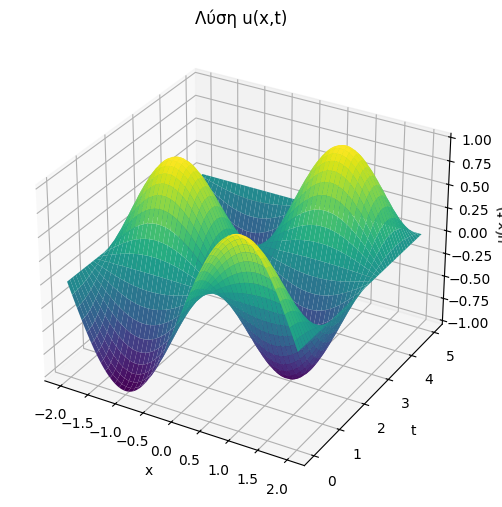

Για t=[0,T] έχουμε min Uanal = -1.000, max Uanal = 1.000
Στο t=Τ έχουμε min Uanal = -0.000, max Uanal = 0.000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#dtype = np.float32
#c = wave_speed.item()
Α = 1
#tmin = tmin.cpu().item()
#tmax = tmax.cpu().item()
#xmin = xmin.cpu().item()
#xmax = xmax.cpu().item()
k = k.cpu()
w = w.cpu()

#σημεία
x = np.linspace(xmin, xmax, 200)
t = np.linspace(tmin, tmax, 200)
X, T = np.meshgrid(x, t)

#λύση κύματος
U_anal = Α * np.sin(k*X)*np.cos(w * T)


#γράφημα
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U_anal, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Λύση u(x,t)')

plt.show()

print(f'Για t=[0,T] έχουμε min Uanal = {U_anal.min():.3f}, max Uanal = {U_anal.max():.3f}')

# Τελικό χρονικό βήμα
Uanal_final = U_anal[:,-1]  # τελευταία γραμμή

# Μέγιστο πλάτος στο t_max
Uanal_min = Uanal_final.min()
Uanal_max = Uanal_final.max()
print(f'Στο t=Τ έχουμε min Uanal = {Uanal_min:.3f}, max Uanal = {Uanal_max:.3f}')

###Διαφορές προσεγγίσεων:

*1) Αναλυτική - Pinn*

*2) Αναλυτική - RK4*

*3) Pinn - RK4*

/tmp/ipython-input-2608824329.py:13: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



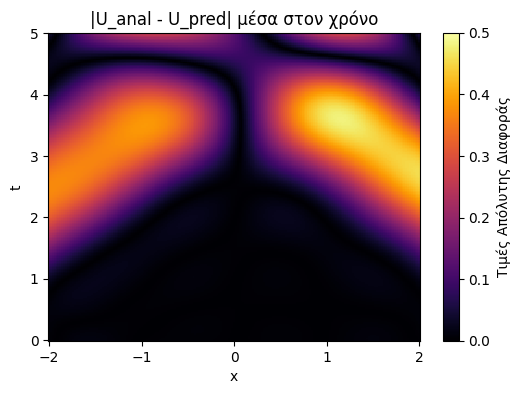

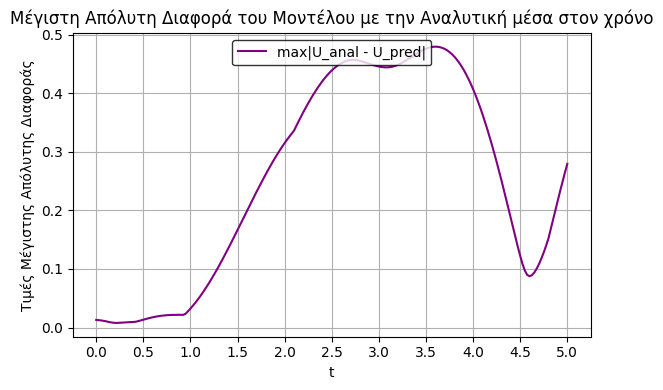

Στο t=Τ έχουμε min U_pred = -0.457, max U_pred = 0.034
Στο t=Τ έχουμε min U_anal = -0.000, max U_anal = 0.000
Μέγιστη Τιμή της max|u_anal - u_pred| = 4.79467677e-01


In [ ]:
#1)Απόλυτες και Μέγιστες Διαφορές του Μοντέλου με την Αναλυτική μέσα στον χρόνο

dtype = torch.float32

N=200

#σημεία
x = np.linspace(xmin, xmax, N+1)
t = np.linspace(tmin, tmax, N+1)
X, T = np.meshgrid(x, t)

#αναλυτική λύση κύματος
U_anal = Α * np.sin(k*X) * np.cos(w * T)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1) και μετατροπή σε numpy
U_pred = upred.detach().numpy().reshape(N+1, N+1)
U_anal_np = U_anal.detach().cpu().numpy()

abs_diff = np.abs(U_pred - U_anal_np)   #απόλυτη διαφορά (Ν+1,Ν+1)
#mean_diff = np.mean(abs_diff, axis=1)   #μέση τιμή διαφοράς (Ν+1,)
max_diff = np.max(abs_diff, axis=1)     #μέγιστη τιμή διαφοράς (Ν+1,)


#γραφήματα

#Πρώτο γράφημα: pcolormesh

#Τα μέγιστα ελάχιστα για την μπάρα
#vmin = np.min(abs_diff)
#vmax = np.max(abs_diff)
vmin = 0.0
vmax = 0.5

plt.figure(figsize=(6,4))
pcm = plt.pcolormesh(X, T, abs_diff, shading='auto', cmap='inferno', vmin=vmin, vmax=vmax)
plt.title('|U_anal - U_pred| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|U_anal - U_pred|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά του Μοντέλου με την Αναλυτική μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(6,4))
plt.plot(t, max_diff, label='max|U_anal - U_pred|', color='purple')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('Μέγιστη Απόλυτη Διαφορά του Μοντέλου με την Αναλυτική μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
U_final = U_pred[:,-1]  # τελευταία γραμμή
Uanal_final = U_anal_np[:,-1]

#Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U_pred = {U_min:.3f}, max U_pred = {U_max:.3f}')

Uanal_min = np.min(Uanal_final)
Uanal_max = np.max(Uanal_final)
print(f'Στο t=Τ έχουμε min U_anal = {Uanal_min:.3f}, max U_anal = {Uanal_max:.3f}')

#Μέγιστη τιμή Απόλυτης Διαφοράς
max_diff_val = np.max(max_diff)
print(f'Μέγιστη Τιμή της max|u_anal - u_pred| = {max_diff_val:10.8e}')

In [ ]:
#ανέβασμα αρχείου Matlab

from google.colab import files
import os
import pandas as pd
import torch

filename = "u_wave_d.csv"

print(os.listdir())  # εμφανίζει όλα τα αρχεία στον φάκελο

#ρωτάω για αντικατάσταση αρχείου
if os.path.exists(filename):
    answer = input(f"Θέλεις να διαγράψω το αρχείο '{filename}' ; (ναι/οχι): ").strip().lower()

    if answer == "ναι":
        os.remove(filename)
        print(f"Το αρχείο '{filename}' διαγράφηκε.")
    else:
        print("Η διαγραφή ακυρώθηκε.")
else:
    print(f"Το αρχείο '{filename}' δεν υπάρχει.")


if os.path.exists(filename):
    print(f"Το αρχείο '{filename}' υπάρχει στον τρέχοντα φάκελο ({os.getcwd()}).")
    df = pd.read_csv(filename, header=None)
else:
    print(f"Το αρχείο '{filename}' ΔΕΝ υπάρχει στον τρέχοντα φάκελο ({os.getcwd()}).")
    upload = files.upload()  # θα ανοίξει παράθυρο για να ανεβάσω το CSV
    upload_filename = list(upload.keys())[0]   # το όνομα του πρώτου αρχείου
    df = pd.read_csv(upload_filename, header=None)

# Μετατροπή σε tensor
U_RK4 = torch.tensor(df.values, dtype=dtype)

print("Μέγεθος u:", U_RK4.shape)


Θέλεις να διαγράψω το αρχείο 'u_wave_d.csv' ; (ναι/οχι): οχι
['.config', 'u_wave_d.csv', 'sample_data']
Η διαγραφή ακυρώθηκε.
Το αρχείο 'u_wave_d.csv' υπάρχει στον τρέχοντα φάκελο (/content).
Μέγεθος u: torch.Size([401, 501])


(501, 401)
(401, 501)


/tmp/ipython-input-1683098244.py:17: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



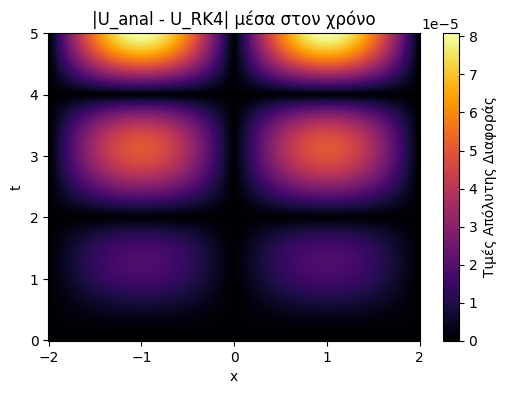

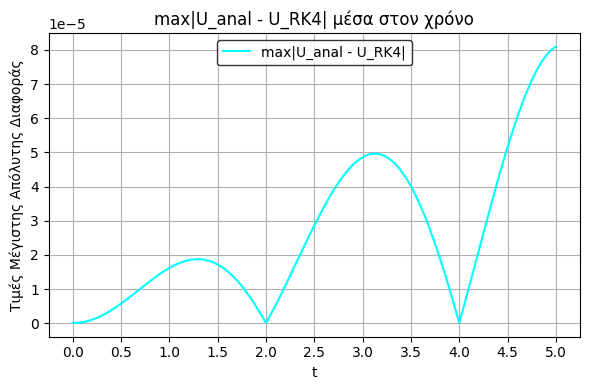

Στο t=Τ έχουμε min U = -0.000, max U = 0.000
Στο t=Τ έχουμε min U_RK4 = -0.000, max U_RK4 = 0.000
Μέγιστη Τιμή της max|u_anal - u_rk4| = 8.09678039e-05


In [ ]:
#2)Διαφορές μεταξύ Μοντέλου και RK4 μέσα στον χρόνο
import numpy as np

#παίρνω τις διαστάσεις από το Matlab
Nx_rk4, Nt_rk4 = U_RK4.shape

#φτιάχνω ίδιες διαστάσεις για το μοντέλο για να επιτευχθεί η αφαίρεση
Nx = Nx_rk4
Nt = Nt_rk4

#σημεία
x = np.linspace(xmin, xmax, Nx)
t = np.linspace(tmin, tmax, Nt)
X, T = np.meshgrid(x, t)

#αναλυτική λύση κύματος
U_anal = Α * np.sin(k*X) * np.cos(w * T)

#μετατροπή σε numpy
U_anal_np = U_anal.detach().cpu().numpy()
U_RK4_np  = U_RK4.detach().cpu().numpy()

print(U_anal_np.shape)
print(U_RK4_np.shape)

abs_diff = np.abs(U_anal_np - U_RK4_np.T) #απόλυτη διαφορά
#mean_diff = np.mean(abs_diff, axis=1)     #μέση τιμή διαφοράς
max_diff = np.max(abs_diff, axis=1)       #μέγιστη τιμή διαφοράς


#γραφήματα

#Πρώτο γράφημα: pcolormesh
plt.figure(figsize=(6,4))
pcm = plt.pcolormesh(X, T, abs_diff, shading='auto', cmap='inferno')
plt.title('|U_anal - U_RK4| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|U_anal - U_RK4|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά της Αναλυτικής με την RK4 μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(6,4))
plt.plot(t, max_diff, label='max|U_anal - U_RK4|', color='cyan')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('max|U_anal - U_RK4| μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
Uanal_final = U_anal_np[:,-1]  # τελευταία γραμμή
URK4_final = U_RK4_np[:,-1]

#Μέγιστο πλάτος στο t_max
Uanal_min = np.min(Uanal_final)
Uanal_max = np.max(Uanal_final)
print(f'Στο t=Τ έχουμε min U = {Uanal_min:.3f}, max U = {Uanal_max:.3f}')

URK4_min = np.min(URK4_final)
URK4_max = np.max(URK4_final)
print(f'Στο t=Τ έχουμε min U_RK4 = {URK4_min:.3f}, max U_RK4 = {URK4_max:.3f}')

#Μέγιστη τιμή Απόλυτης Διαφοράς
max_diff_val = np.max(max_diff)
print(f'Μέγιστη Τιμή της max|u_anal - u_rk4| = {max_diff_val:10.8e}')

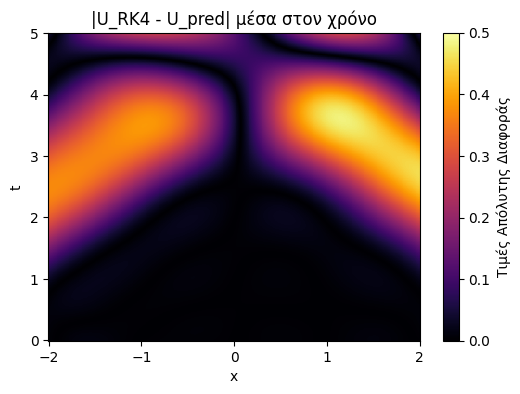

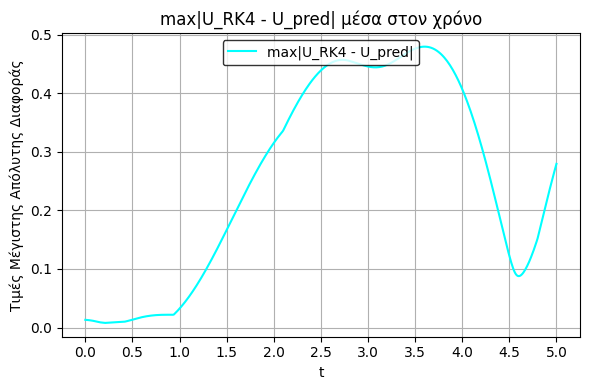

Στο t=Τ έχουμε min U_pred = -0.457, max U_pred = 0.034
Στο t=Τ έχουμε min U_RK4 = -0.000, max U_RK4 = 0.000
Μέγιστη Τιμή της max|u_rk4 - u_pred| = 4.79434490e-01


In [ ]:
#3)Διαφορές του Μοντέλου με την RK4 μέσα στον χρόνο

#dtype = torch.float32

#παίρνω τις διαστάσεις από το Matlab
Nx_rk4, Nt_rk4 = U_RK4.shape

#φτιάχνω ίδιες διαστάσεις για το μοντέλο για να επιτευχθεί η αφαίρεση
Nx = Nx_rk4
Nt = Nt_rk4

#σημεία
x = np.linspace(xmin, xmax, Nx)
t = np.linspace(tmin, tmax, Nt)
X, T = np.meshgrid(x, t)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T.flatten(),X.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1) και μετατροπή σε numpy
U_pred = upred.detach().numpy().reshape(Nt, Nx)
U_RK4_np  = U_RK4.detach().cpu().numpy()

abs_diff = np.abs(U_pred - U_RK4_np.T) #απόλυτη διαφορά (Ν+1,Ν+1)
#mean_diff = np.mean(abs_diff, axis=1)      #μέση τιμή διαφοράς (Ν+1,)
max_diff = np.max(abs_diff, axis=1)        #μέγιστη τιμή διαφοράς (Ν+1,)


#γραφήματα

#Πρώτο γράφημα: pcolormesh

#Τα μέγιστα ελάχιστα για την μπάρα
#vmin = np.min(abs_diff)
#vmax = np.max(abs_diff)
vmin = 0.0
vmax = 0.5

plt.figure(figsize=(6,4))
pcm = plt.pcolormesh(X, T, abs_diff, shading='auto', cmap='inferno', vmin=vmin, vmax=vmax)
plt.title('|U_RK4 - U_pred| μέσα στον χρόνο')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(pcm, label='Τιμές Απόλυτης Διαφοράς')

#Δεύτερο γράφημα: γραμμικό
#plt.figure(figsize=(10,4))
#plt.plot(t, mean_diff, label='mean|U_RK4 - U_pred|', color='purple')
#plt.xlabel('t')
#plt.ylabel('Τιμές Μέσης Απόλυτης Διαφοράς')
#plt.title('Μέση Απόλυτη Διαφορά του Μοντέλου με την RK4 μέσα στον χρόνο')
#plt.legend(loc='upper center').get_frame().set_edgecolor('black')
#plt.xticks(np.arange(0, tmax+0.1, 0.5))
#plt.grid(True)

#Τρίτο γράφημα: γραμμικό
plt.figure(figsize=(6,4))
plt.plot(t, max_diff, label='max|U_RK4 - U_pred|', color='cyan')
plt.xlabel('t')
plt.ylabel('Τιμές Μέγιστης Απόλυτης Διαφοράς')
plt.title('max|U_RK4 - U_pred| μέσα στον χρόνο')
plt.legend(loc='upper center').get_frame().set_edgecolor('black')
plt.xticks(np.arange(0, tmax+0.1, 0.5))
plt.grid(True)

plt.tight_layout()  # για να μην κολλάνε οι τίτλοι/άξονες
plt.show()

#Τελικό χρονικό βήμα
U_final = U_pred[:,-1]  # τελευταία γραμμή
URK4_final = U_RK4_np[:,-1]

#Μέγιστο πλάτος στο t_max
U_min = np.min(U_final)
U_max = np.max(U_final)
print(f'Στο t=Τ έχουμε min U_pred = {U_min:.3f}, max U_pred = {U_max:.3f}')

URK4_min = np.min(URK4_final)
URK4_max = np.max(URK4_final)
print(f'Στο t=Τ έχουμε min U_RK4 = {URK4_min:.3f}, max U_RK4 = {URK4_max:.3f}')

#Μέγιστη τιμή Απόλυτης Διαφοράς
max_diff_val = np.max(max_diff)
print(f'Μέγιστη Τιμή της max|u_rk4 - u_pred| = {max_diff_val:10.8e}')

x shape: (1001,)
t shape: (1001,)
U shape: (1001, 1001)
U_smooth shape: (1001, 1001)

[tmin,tmax] x [xmin,xmax]
[0.0, 5.0] x [-2.0, 2.0]

Παγκόσμιο max u = +1.05723429
Παγκόσμιο min u = -1.02086997

Φιλτραρισμένο max = +1.05723429
Φιλτραρισμένο min = -1.02086997

Τοπικά Μέγιστα:
1) u = +1.05723429 στο (x=-1.12, t=+2.12)
2) u = +0.99885541 στο (x=+0.99, t=+0.00)
3) u = +0.64192492 στο (x=+1.02, t=+4.26)

Τοπικά Ελάχιστα:
1) u = -0.72926116 στο (x=-1.02, t=+4.18)
2) u = -1.00084805 στο (x=-0.99, t=+0.00)
3) u = -1.02086997 στο (x=+1.09, t=+2.07)


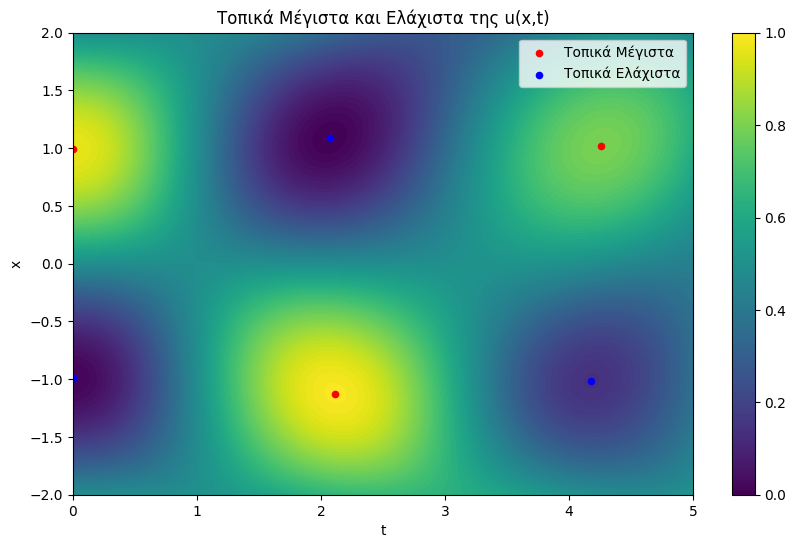

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import matplotlib.pyplot as plt

#Πλήθος διαστημάτων
N = 1000

#Δημιουργία σημείων
t_mm = np.linspace(tmin, tmax, N + 1) #(N+1,1)
x_mm = np.linspace(xmin, xmax, N + 1) #(N+1,1)

#Δημιουργία πλέγματος σημείων
T_mm, X_mm = np.meshgrid(t_mm, x_mm) #(N+1,N+1) , (N+1,N+1)

#κάθε γραμμή ένα σημείο του πλέγματος
Xgrid = np.vstack([T_mm.flatten(),X_mm.flatten()]).T #((Ν+1)^2,2)

#Υπολογίζει τις προβλέψεις u(t, x) του μοντέλου
upred = model(torch.tensor(Xgrid,dtype=dtype)) #((Ν+1)^2,1)

#Από ((Ν+1)^2,1) σε (Ν+1,Ν+1)
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

#Εξομάλυνση των δεδομένων με Γκαουσιανό φίλτρο σ=1
U_smooth = gaussian_filter(U.T, sigma=1)

#Εφαρμογή φίλτρων μέγιστου και ελάχιστου για ανίχνευση τοπικών σημείων με φίλτρο
filter_mm = 0.5
local_max = ((U_smooth == maximum_filter(U_smooth, size=3)) & (U_smooth>filter_mm))
local_min = ((U_smooth == minimum_filter(U_smooth, size=3)) & (U_smooth<-filter_mm))

#Συντεταγμένες των τοπικών μεγίστων και τοπικών ελαχίστων
max_coords = np.argwhere(local_max)
min_coords = np.argwhere(local_min)

print(f'x shape: {x_mm.shape}')
print(f't shape: {t_mm.shape}')
print(f'U shape: {U.shape}')
print(f'U_smooth shape: {U_smooth.shape}')
print(f'\n[tmin,tmax] x [xmin,xmax]')
print(f'[{tmin}, {tmax}] x [{xmin}, {xmax}]')
print(f'\nΠαγκόσμιο max u = {np.max(U):+.8f}')
print(f'Παγκόσμιο min u = {np.min(U):+.8f}')

#Εξαγωγή τιμών και συντεταγμένων μεγίστων
t_max_mm = t_mm[max_coords[:, 0]]
x_max_mm = x_mm[max_coords[:, 1]]
u_max_mm = U[max_coords[:, 1], max_coords[:, 0]]

#Ταξινόμηση ως προς x σε αύξουσα σειρά
sorted_idx_max = np.argsort(x_max_mm)
t_max_mm = t_max_mm[sorted_idx_max]
x_max_mm = x_max_mm[sorted_idx_max]
u_max_mm = np.atleast_1d(u_max_mm[sorted_idx_max])

#Εξαγωγή τιμών και συντεταγμένων ελαχίστων
t_min_mm = t_mm[min_coords[:, 0]]
x_min_mm = x_mm[min_coords[:, 1]]
u_min_mm = U[min_coords[:, 1], min_coords[:, 0]]

#Ταξινόμηση ως προς x σε αύξουσα σειρά
sorted_idx_min = np.argsort(x_min_mm)
t_min_mm = t_min_mm[sorted_idx_min]
x_min_mm = x_min_mm[sorted_idx_min]
u_min_mm = np.atleast_1d(u_min_mm[sorted_idx_min])

print(f'\nΦιλτραρισμένο max = {np.max(u_max_mm):+.8f}')
print(f'Φιλτραρισμένο min = {np.min(u_min_mm):+.8f}')

print('\nΤοπικά Μέγιστα:')
for i in range(len(u_max_mm)):
    print(f"{i+1}) u = {u_max_mm[i]:+.8f} στο (x={x_max_mm[i]:+.2f}, t={t_max_mm[i]:+.2f})")

print('\nΤοπικά Ελάχιστα:')
for i in range(len(u_min_mm)):
    print(f"{i+1}) u = {u_min_mm[i]:+.8f} στο (x={x_min_mm[i]:+.2f}, t={t_min_mm[i]:+.2f})")

#Εμφάνιση αποτελεσμάτων σε γράφημα
plt.figure(figsize=(10, 6))

#plt.contourf(x_mm, t_mm, U.T, 100, cmap='viridis')
#plt.scatter(x_max_mm, t_max_mm, color='red', label='Τοπικά Μέγιστα', s=20)
#plt.scatter(x_min_mm, t_min_mm, color='blue', label='Τοπικά Ελάχιστα', s=20)
#plt.xlabel("x")
#plt.ylabel("t")

plt.contourf(t_mm, x_mm, U, 100, cmap='viridis')
plt.scatter(t_max_mm, x_max_mm, color='red', label='Τοπικά Μέγιστα', s=20)
plt.scatter(t_min_mm, x_min_mm, color='blue', label='Τοπικά Ελάχιστα', s=20)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar()
plt.legend()
plt.title("Τοπικά Μέγιστα και Ελάχιστα της u(x,t)")
plt.show()